<a href="https://colab.research.google.com/github/maruvadaItis/MovieMahal/blob/master/Genre_Classifier_based_onPlots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

import pickle 
#import mglearn
import time


from nltk.tokenize import TweetTokenizer 
import nltk
from nltk import Text
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import word_tokenize  
from nltk.tokenize import sent_tokenize 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC



In [2]:
movies = pd.read_csv('/content/movies.csv', delimiter=',')
movies.dataframeName = 'movies.csv'
nRow, nCol = movies.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 45466 rows and 4 columns


In [3]:
movies.head()

,movieId,Title,Genre,Plot
0,1.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"Led by Woody, Andy's toys live happily in his ..."
1,2.0,Jumanji (1995),Adventure|Children|Fantasy,When siblings Judy and Peter discover an encha...
2,3.0,Grumpier Old Men (1995),Comedy|Romance,A family wedding reignites the ancient feud be...
3,4.0,Waiting to Exhale (1995),Comedy|Drama|Romance,"Cheated on, mistreated and stepped on, the wom..."
4,5.0,Father of the Bride Part II (1995),Comedy,Just when George Banks has recovered from his ...


In [4]:
movies['Count']=1
movies[['Genre','Count']].groupby(['Genre'], as_index=False).count().shape[0]

1342

In [0]:
movies['RightGenre'] =movies['Genre'] 
movies['RightGenre']=movies['RightGenre'].str.strip()
movies['RightGenre']=movies['RightGenre'].str.replace(' - ', '|')
movies['RightGenre']=movies['RightGenre'].str.replace(' / ', '|')
movies['RightGenre']=movies['RightGenre'].str.replace('/', '|')
movies['RightGenre']=movies['RightGenre'].str.replace(' & ', '|')
movies['RightGenre']=movies['RightGenre'].str.replace(', ', '|')
movies['RightGenre']=movies['RightGenre'].str.replace('; ', '|')
movies['RightGenre']=movies['RightGenre'].str.replace(' ','|')
movies['RightGenre']=movies['RightGenre'].str.replace(',','|')
movies['RightGenre']=movies['RightGenre'].str.replace('-','')


In [6]:

moviesGenre = movies[['RightGenre','Count']].groupby(['RightGenre']).count()
moviesGenre.to_csv('RightGenre.csv',sep=',')
movies[['RightGenre','Count']].groupby(['RightGenre'], as_index=False).count().shape[0]

1342

In [7]:

movies[['RightGenre','Count']].groupby(['RightGenre'],as_index=False).count().sort_values(['Count'], ascending=False).head(10)

,RightGenre,Count
1142,Drama,4520
893,Comedy,2294
1119,Documentary,1942
938,Comedy|Drama,1264
1222,Drama|Romance,1075
1028,Comedy|Romance,757
968,Comedy|Drama|Romance,605
1280,Horror,565
1047,Crime|Drama,448
1236,Drama|Thriller,426


In [0]:
movies['RightGenre'] = movies['RightGenre'].apply(str)

In [9]:
movies['GenreSplit']=movies['RightGenre'].str.split('|')
movies['GenreSplit']= movies['GenreSplit'].apply(np.sort).apply(np.unique)
movies['GenreSplit'][11]



array(['Comedy', 'Horror'], dtype='<U6')

In [10]:
genres_array = np.array([])

for i in range(0,movies.shape[0]-1):
    genres_array = np.concatenate((genres_array, movies['GenreSplit'][i] ))
    
genres_array

array(['Adventure', 'Animation', 'Children', ..., 'nan', 'nan', 'nan'],
      dtype='<U32')

In [11]:

genres = pd.DataFrame({'Genre':genres_array})

genres.head(10)

,Genre
0,Adventure
1,Animation
2,Children
3,Comedy
4,Fantasy
5,Adventure
6,Children
7,Fantasy
8,Comedy
9,Romance


In [12]:
genres['Count']=1
genres[['Genre','Count']].groupby(['Genre'], as_index=False).sum().sort_values(['Count'], ascending=False).head(10)

,Genre,Count
22,nan,18187
8,Drama,13344
5,Comedy,8374
17,Thriller,4178
15,Romance,4127
1,Action,3520
6,Crime,2939
11,Horror,2611
7,Documentary,2471
2,Adventure,2329


In [13]:
genres=genres[['Genre','Count']].groupby(['Genre'], as_index=False).sum().sort_values(['Count'], ascending=False)
genres = genres[genres['Genre']!='']
genres.head(30)

,Genre,Count
22,nan,18187
8,Drama,13344
5,Comedy,8374
17,Thriller,4178
15,Romance,4127
1,Action,3520
6,Crime,2939
11,Horror,2611
7,Documentary,2471
2,Adventure,2329


In [14]:
TotalCountGenres=sum(genres['Count'])
TotalCountGenres

73085

In [15]:
genres['Frequency'] = genres['Count']/TotalCountGenres
genres['CumulativeFrequency'] = genres['Frequency'].cumsum()
genres.head(20)

,Genre,Count,Frequency,CumulativeFrequency
22,nan,18187,0.248847,0.248847
8,Drama,13344,0.182582,0.431429
5,Comedy,8374,0.114579,0.546008
17,Thriller,4178,0.057166,0.603174
15,Romance,4127,0.056468,0.659643
1,Action,3520,0.048163,0.707806
6,Crime,2939,0.040213,0.748019
11,Horror,2611,0.035726,0.783745
7,Documentary,2471,0.033810,0.817555
2,Adventure,2329,0.031867,0.849422


In [16]:
np.array(genres[genres['CumulativeFrequency']<=.985]['Genre'])

array(['nan', 'Drama', 'Comedy', 'Thriller', 'Romance', 'Action', 'Crime',
       'Horror', 'Documentary', 'Adventure', 'SciFi', 'Mystery',
       'Fantasy', 'War', 'Children', 'Musical', 'Animation', 'Western'],
      dtype=object)

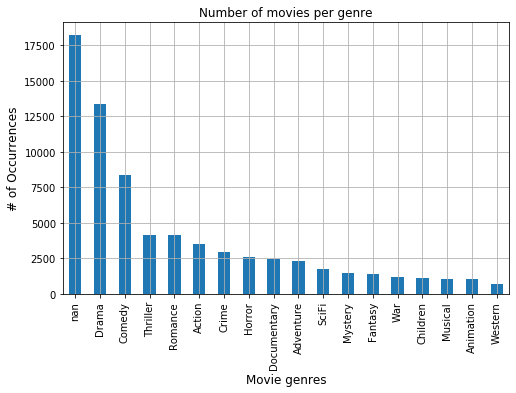

In [17]:
genres[genres['CumulativeFrequency']<=.985][['Genre','Count']].plot(x='Genre', y='Count', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of movies per genre")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Movie genres', fontsize=12)
plt.show()

In [18]:
mainGenres=np.array(genres[genres['CumulativeFrequency']<=.957]['Genre'])
arr1=np.array(['horror', 'romance', 'scifi','and'])
arr1[np.in1d(arr1,mainGenres)]

array([], dtype='<U7')

In [19]:
movies['GenreSplit'][10:12].apply(lambda x: x[np.in1d(x,mainGenres)])

10    [Comedy, Drama, Romance]
11            [Comedy, Horror]
Name: GenreSplit, dtype: object

In [20]:
movies['SplittinMainGenre'] = movies['GenreSplit'].apply(lambda x: x[np.in1d(x,mainGenres)])
movies[['SplittinMainGenre','GenreSplit','Genre']][200:220]

,SplittinMainGenre,GenreSplit,Genre
200,"[Drama, Romance]","[Drama, Romance]",Drama|Romance
201,[Comedy],[Comedy],Comedy
202,[Action],[Action],Action
203,"[Comedy, Drama]","[Comedy, Drama]",Comedy|Drama
204,[Documentary],[Documentary],Documentary
205,"[Drama, Romance]","[Drama, Romance]",Drama|Romance
206,"[Action, Adventure, SciFi]","[Action, Adventure, SciFi]",Action|Adventure|Sci-Fi
207,[Drama],[Drama],Drama
208,[],[Western],Western
209,[Drama],[Drama],Drama


In [0]:

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    #text = re.sub('\W', ' ', text)
    #text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [22]:
#list(movies['overview'][10:12].apply(clean_text))

#movies['overview']=movies['overview'].apply(str)

list(movies['Plot'][10:12].apply(clean_text))




['widowed u.s. president andrew shepherd, one of the world  most powerful men, can have anything he wants -- and what he covets most is sydney ellen wade, a washington lobbyist. but shepherd  attempts at courting her spark wild rumors and decimate his approval ratings.',
 'when a lawyer shows up at the vampire  doorstep, he falls prey to his charms and joins him in his search for fresh blood. enter dr. van helsing, who may be the only one able to vanquish the count.']

In [23]:
list(movies['Plot'][10:12])

["Widowed U.S. president Andrew Shepherd, one of the world's most powerful men, can have anything he wants -- and what he covets most is Sydney Ellen Wade, a Washington lobbyist. But Shepherd's attempts at courting her spark wild rumors and decimate his approval ratings.",
 "When a lawyer shows up at the vampire's doorstep, he falls prey to his charms and joins him in his search for fresh blood. Enter Dr. van Helsing, who may be the only one able to vanquish the count."]

In [0]:
movies['Plot']=movies['Plot'].apply(str)

movies['PlotClean'] = movies['Plot'].apply(clean_text)


In [25]:
movies[['Plot','PlotClean']][6:12]

,Plot,PlotClean
6,An ugly duckling having undergone a remarkable...,an ugly duckling having undergone a remarkable...
7,"A mischievous young boy, Tom Sawyer, witnesses...","a mischievous young boy, tom sawyer, witnesses..."
8,International action superstar Jean Claude Van...,international action superstar jean claude van...
9,James Bond must unmask the mysterious head of ...,james bond must unmask the mysterious head of ...
10,"Widowed U.S. president Andrew Shepherd, one of...","widowed u.s. president andrew shepherd, one of..."
11,When a lawyer shows up at the vampire's doorst...,when a lawyer shows up at the vampire doorste...


In [26]:
movies[['Plot','PlotClean','SplittinMainGenre']][6:12]

,Plot,PlotClean,SplittinMainGenre
6,An ugly duckling having undergone a remarkable...,an ugly duckling having undergone a remarkable...,"[Comedy, Romance]"
7,"A mischievous young boy, Tom Sawyer, witnesses...","a mischievous young boy, tom sawyer, witnesses...","[Adventure, Children]"
8,International action superstar Jean Claude Van...,international action superstar jean claude van...,[Action]
9,James Bond must unmask the mysterious head of ...,james bond must unmask the mysterious head of ...,"[Action, Adventure, Thriller]"
10,"Widowed U.S. president Andrew Shepherd, one of...","widowed u.s. president andrew shepherd, one of...","[Comedy, Drama, Romance]"
11,When a lawyer shows up at the vampire's doorst...,when a lawyer shows up at the vampire doorste...,"[Comedy, Horror]"


In [27]:
len(movies['SplittinMainGenre'][0])

4

In [28]:
movies['SplittinMainGenre'][0:5].apply(len)

0    4
1    3
2    2
3    3
4    1
Name: SplittinMainGenre, dtype: int64

In [29]:
movies['CountOfMainGenres'] = movies['SplittinMainGenre'].apply(len)

max(movies['CountOfMainGenres'] )                     
                          


8

In [30]:
movies[movies['CountOfMainGenres']==8]

,movieId,Title,Genre,Plot,Count,RightGenre,GenreSplit,SplittinMainGenre,PlotClean,CountOfMainGenres
4922,5018.0,Motorama (1991),Adventure|Comedy|Crime|Drama|Fantasy|Mystery|S...,Is today's fanaticism tomorrow's policy? In a ...,1,Adventure|Comedy|Crime|Drama|Fantasy|Mystery|S...,"[Adventure, Comedy, Crime, Drama, Fantasy, Mys...","[Adventure, Comedy, Crime, Drama, Fantasy, Mys...",is today fanaticism tomorrow policy? in a we...,8
16024,81132.0,Rubber (2010),Action|Adventure|Comedy|Crime|Drama|Film-Noir|...,"A unique 16th century woman, Danielle possesse...",1,Action|Adventure|Comedy|Crime|Drama|FilmNoir|H...,"[Action, Adventure, Comedy, Crime, Drama, Film...","[Action, Adventure, Comedy, Crime, Drama, Horr...","a unique 16th century woman, danielle possesse...",8


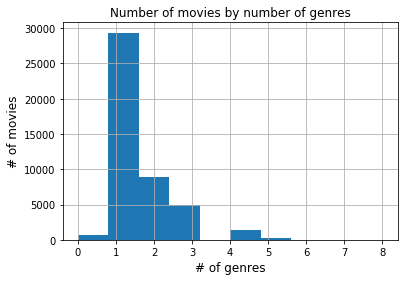

In [31]:
movies['CountOfMainGenres'].hist()

plt.title("Number of movies by number of genres")
plt.ylabel('# of movies', fontsize=12)
plt.xlabel('# of genres', fontsize=12)
plt.show()

In [32]:
movies.SplittinMainGenre[0:19].apply(lambda x: '-'.join(x)).str.split(pat='-',n=5,expand=True)

,0,1,2,3
0,Adventure,Children,Comedy,Fantasy
1,Adventure,Children,Fantasy,None
2,Comedy,Romance,None,None
3,Comedy,Drama,Romance,None
4,Comedy,None,None,None
5,Action,Crime,Thriller,None
6,Comedy,Romance,None,None
7,Adventure,Children,None,None
8,Action,None,None,None
9,Action,Adventure,Thriller,None


In [33]:
movies.SplittinMainGenre[6:15].apply(lambda x: '-'.join(x)).str.get_dummies(sep='-')

,Action,Adventure,Children,Comedy,Drama,Horror,Romance,Thriller
6,0,0,0,1,0,0,1,0
7,0,1,1,0,0,0,0,0
8,1,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,1
10,0,0,0,1,1,0,1,0
11,0,0,0,1,0,1,0,0
12,0,1,1,0,0,0,0,0
13,0,0,0,0,1,0,0,0
14,1,1,0,0,0,0,1,0


In [34]:
movies.SplittinMainGenre[6:15]

6                 [Comedy, Romance]
7             [Adventure, Children]
8                          [Action]
9     [Action, Adventure, Thriller]
10         [Comedy, Drama, Romance]
11                 [Comedy, Horror]
12            [Adventure, Children]
13                          [Drama]
14     [Action, Adventure, Romance]
Name: SplittinMainGenre, dtype: object

In [35]:
movies.columns

Index(['movieId', 'Title', 'Genre', 'Plot', 'Count', 'RightGenre',
       'GenreSplit', 'SplittinMainGenre', 'PlotClean', 'CountOfMainGenres'],
      dtype='object')

In [36]:
movies.shape

(45466, 10)

In [37]:
len(movies.Title.unique())

27263

In [38]:
movies[movies.RightGenre==''].shape

(0, 10)

In [0]:
movies = pd.concat([movies, movies.SplittinMainGenre.apply(lambda x: '-'.join(x)).str.get_dummies(sep='-')], axis=1)

In [0]:
MoviesTrain, MoviesTest = train_test_split(movies[movies.RightGenre!=''], random_state=42, test_size=0.30, shuffle=True)

In [0]:
tfidf = TfidfVectorizer(stop_words ='english', smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word')

In [0]:
x_train = tfidf.fit_transform(MoviesTrain.PlotClean) 
x_test  = tfidf.transform(MoviesTest.PlotClean)

In [43]:
print('nrow of the MoviesTrain ={}'. format(MoviesTrain.shape[0]))

nrow of the MoviesTrain =31826


In [44]:
print('nrow of the MoviesTest ={}'. format(MoviesTest.shape[0]))

nrow of the MoviesTest =13640


In [45]:
type(x_train)

scipy.sparse.csr.csr_matrix

In [46]:
x_train.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [47]:
tfidf.inverse_transform(x_train[0].toarray())

[array(['clairvoyant', 'crime', 'falls', 'involved', 'love', 'murderer',
        'pathological', 'photographer', 'search', 'soon', 'story'],
       dtype='<U22')]

In [48]:
print('The corpus is large. It contain {} words.'.format(len(x_train[0].toarray()[0])))

The corpus is large. It contain 38314 words.


In [0]:
y_train = MoviesTrain[MoviesTrain.columns[10:]]
y_test = MoviesTest[MoviesTest.columns[10:]]

In [50]:
len(y_train.columns)


15

In [51]:
len(y_test.columns)

15

In [52]:
linearSVC=OneVsRestClassifier(LinearSVC(), n_jobs=1)
accuracy_LinearSVC=pd.DataFrame(columns=['Genre', 'accuracy_LinearSVC'])
accuracy_LinearSVC.head()

,Genre,accuracy_LinearSVC


In [53]:
i = 0
for genre in mainGenres:
    linearSVC.fit(x_train, y_train[genre])
    prediction = linearSVC.predict(x_test)
    accuracy_LinearSVC.loc[i,'Genre'] = genre
    accuracy_LinearSVC.loc[i,'accuracy_LinearSVC'] = accuracy_score(y_test[genre], prediction)
    i=i+1

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [54]:
accuracy_LinearSVC

,Genre,accuracy_LinearSVC
0,nan,0.344795
1,Drama,0.541789
2,Comedy,0.676613
3,Thriller,0.830792
4,Romance,0.830865
5,Action,0.857478
6,Crime,0.880352
7,Horror,0.892595
8,Documentary,0.902933
9,Adventure,0.907991


In [55]:
multinomialNB=OneVsRestClassifier(MultinomialNB(fit_prior=False, class_prior=None))



accuracy_multinomialNB=pd.DataFrame(columns=['Genre', 'accuracy_multinomialNB'])
accuracy_multinomialNB.head()

,Genre,accuracy_multinomialNB


In [0]:
i = 0
for genre in mainGenres:
    multinomialNB.fit(x_train, y_train[genre])
    prediction = multinomialNB.predict(x_test)
    accuracy_multinomialNB.loc[i,'Genre'] = genre
    accuracy_multinomialNB.loc[i,'accuracy_multinomialNB'] = accuracy_score(y_test[genre], prediction)
    i=i+1
  

In [57]:
accuracy_multinomialNB

,Genre,accuracy_multinomialNB
0,nan,0.279985
1,Drama,0.488856
2,Comedy,0.594575
3,Thriller,0.743915
4,Romance,0.745894
5,Action,0.77588
6,Crime,0.811657
7,Horror,0.812757
8,Documentary,0.830865
9,Adventure,0.839076


In [0]:
accuracy_svc_mnb = pd.merge(accuracy_multinomialNB, accuracy_LinearSVC, on='Genre', how='inner')

In [59]:
accuracy_svc_mnb

,Genre,accuracy_multinomialNB,accuracy_LinearSVC
0,nan,0.279985,0.344795
1,Drama,0.488856,0.541789
2,Comedy,0.594575,0.676613
3,Thriller,0.743915,0.830792
4,Romance,0.745894,0.830865
5,Action,0.77588,0.857478
6,Crime,0.811657,0.880352
7,Horror,0.812757,0.892595
8,Documentary,0.830865,0.902933
9,Adventure,0.839076,0.907991


In [0]:
accuracy_multinomialNB1 = accuracy_multinomialNB
accuracy_multinomialNB1.columns = ['Genre', 'accuracy']
accuracy_multinomialNB1['classifier'] = 'multinomialNB'


In [61]:
accuracy_multinomialNB1

,Genre,accuracy,classifier
0,nan,0.279985,multinomialNB
1,Drama,0.488856,multinomialNB
2,Comedy,0.594575,multinomialNB
3,Thriller,0.743915,multinomialNB
4,Romance,0.745894,multinomialNB
5,Action,0.77588,multinomialNB
6,Crime,0.811657,multinomialNB
7,Horror,0.812757,multinomialNB
8,Documentary,0.830865,multinomialNB
9,Adventure,0.839076,multinomialNB


In [0]:
accuracy_LinearSVC1 = accuracy_LinearSVC
accuracy_LinearSVC1.columns = ['Genre', 'accuracy']
accuracy_LinearSVC1['classifier'] = 'linearSVC'


In [63]:
accuracy_LinearSVC1

,Genre,accuracy,classifier
0,nan,0.344795,linearSVC
1,Drama,0.541789,linearSVC
2,Comedy,0.676613,linearSVC
3,Thriller,0.830792,linearSVC
4,Romance,0.830865,linearSVC
5,Action,0.857478,linearSVC
6,Crime,0.880352,linearSVC
7,Horror,0.892595,linearSVC
8,Documentary,0.902933,linearSVC
9,Adventure,0.907991,linearSVC


In [64]:
accu_mnb_svc = accuracy_multinomialNB1.append(accuracy_LinearSVC1)
accu_mnb_svc

,Genre,accuracy,classifier
0,nan,0.279985,multinomialNB
1,Drama,0.488856,multinomialNB
2,Comedy,0.594575,multinomialNB
3,Thriller,0.743915,multinomialNB
4,Romance,0.745894,multinomialNB
5,Action,0.77588,multinomialNB
6,Crime,0.811657,multinomialNB
7,Horror,0.812757,multinomialNB
8,Documentary,0.830865,multinomialNB
9,Adventure,0.839076,multinomialNB


[Text(0, 0, 'nan'),
 Text(0, 0, 'Drama'),
 Text(0, 0, 'Comedy'),
 Text(0, 0, 'Thriller'),
 Text(0, 0, 'Romance'),
 Text(0, 0, 'Action'),
 Text(0, 0, 'Crime'),
 Text(0, 0, 'Horror'),
 Text(0, 0, 'Documentary'),
 Text(0, 0, 'Adventure'),
 Text(0, 0, 'SciFi'),
 Text(0, 0, 'Mystery'),
 Text(0, 0, 'Fantasy'),
 Text(0, 0, 'War'),
 Text(0, 0, 'Children')]

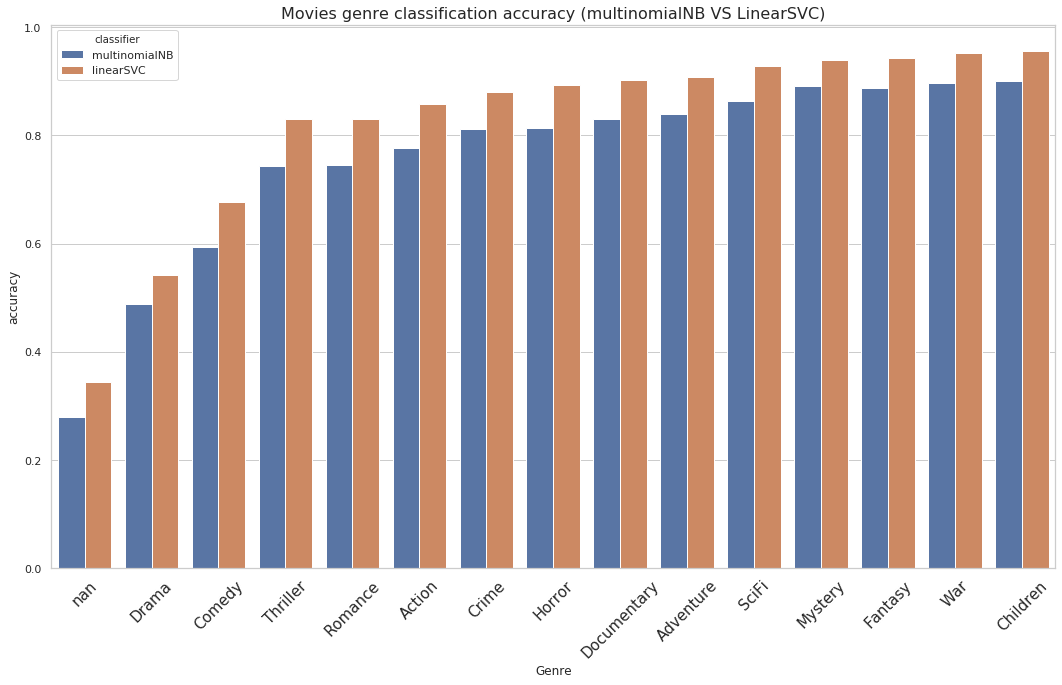

In [65]:
sns.set(rc={'figure.figsize':(18,10)})
sns.set(style="whitegrid")
s = sns.barplot(x="Genre", y="accuracy", hue="classifier", data=accu_mnb_svc) #.set_title('Movies genre classification accuracy (multinomialNB VS LinearSVC)')
s.set_title('Movies genre classification accuracy (multinomialNB VS LinearSVC)', size=16)
s.set_xticklabels(list(mainGenres) ,rotation=45, size=15)

In [66]:
len(mainGenres)

15